In [1]:
using DelimitedFiles, FITSIO
using NearestNeighbors, Distances

using SpatialJackknife

# for plotting
import Cairo, Fontconfig
using Gadfly

┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /home/kilian/.julia/packages/Compose/s2eXf/src/Compose.jl:164
┌ Warning: [TEMPORARY WORKAROUND, pangolayout] for plotting with Gadfly.jl, see https://github.com/GiovineItalia/Gadfly.jl/issues/1206
└ @ Compose /home/kilian/.julia/packages/Compose/s2eXf/src/pango.jl:67
┌ Warning: Error requiring Fontconfig from Compose:
│ LoadError: UndefVarError: pango_cairo_ctx not defined
│ Stacktrace:
│  [1] Compose.PangoLayout() at /home/kilian/.julia/packages/Compose/s2eXf/src/pango.jl:59
│  [2] top-level scope at none:0
│  [3] include at ./boot.jl:317 [inlined]
│  [4] include_relative(::Module, ::String) at ./loading.jl:1038
│  [5] include at ./sysimg.jl:29 [inlined]
│  [6] include(::String) at /home/kilian/.julia/packages/Compose/s2eXf/src/Compose.jl:1
│  [7] top-level scope at /home/kilian/.julia/packages/Compose/s2eXf/src/Compose.jl:172
│  [8] eval at ./boot.jl:319 [inlined]
│  [9] eval at /home/kilian/.julia/packages/Compose/s2eXf/src/C

First we load some data from the SDSS DR7, specifically the data available in the NYU-VAGC catalog which can be found here:

http://cosmo.nyu.edu/blanton/vagc

First we load the randoms and the target data, to find the subvolumes. For proper treatment, it would be better to use the full set of randoms but, for the purpose of illustration, I use only one set, which is similar in size to the data itself.

In [2]:
rands = readdlm("../dat/lss_random-0.dr72.dat")
rands = rands[:, 1:2]  # just keep the RA and Dec values

f = FITS("../dat/object_catalog.fits")
ra = read(f[2], "RA")
dec = read(f[2], "DEC")
dat = hcat(ra, dec)
close(f)

### Computing subvolumes

In [3]:
# now to get the subvolume indices of the data based on the randoms
# we choose to get a 5x5 grid of subvolumes in the survey mask, and use Haversine distance
subvols = get_subvols(dat, rands, 5, Distances.Haversine(1.0))

2506754-element Array{Int64,1}:
 21
 21
 21
 21
 21
 21
 21
 21
 21
 21
 21
 21
 21
  ⋮
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7
  7

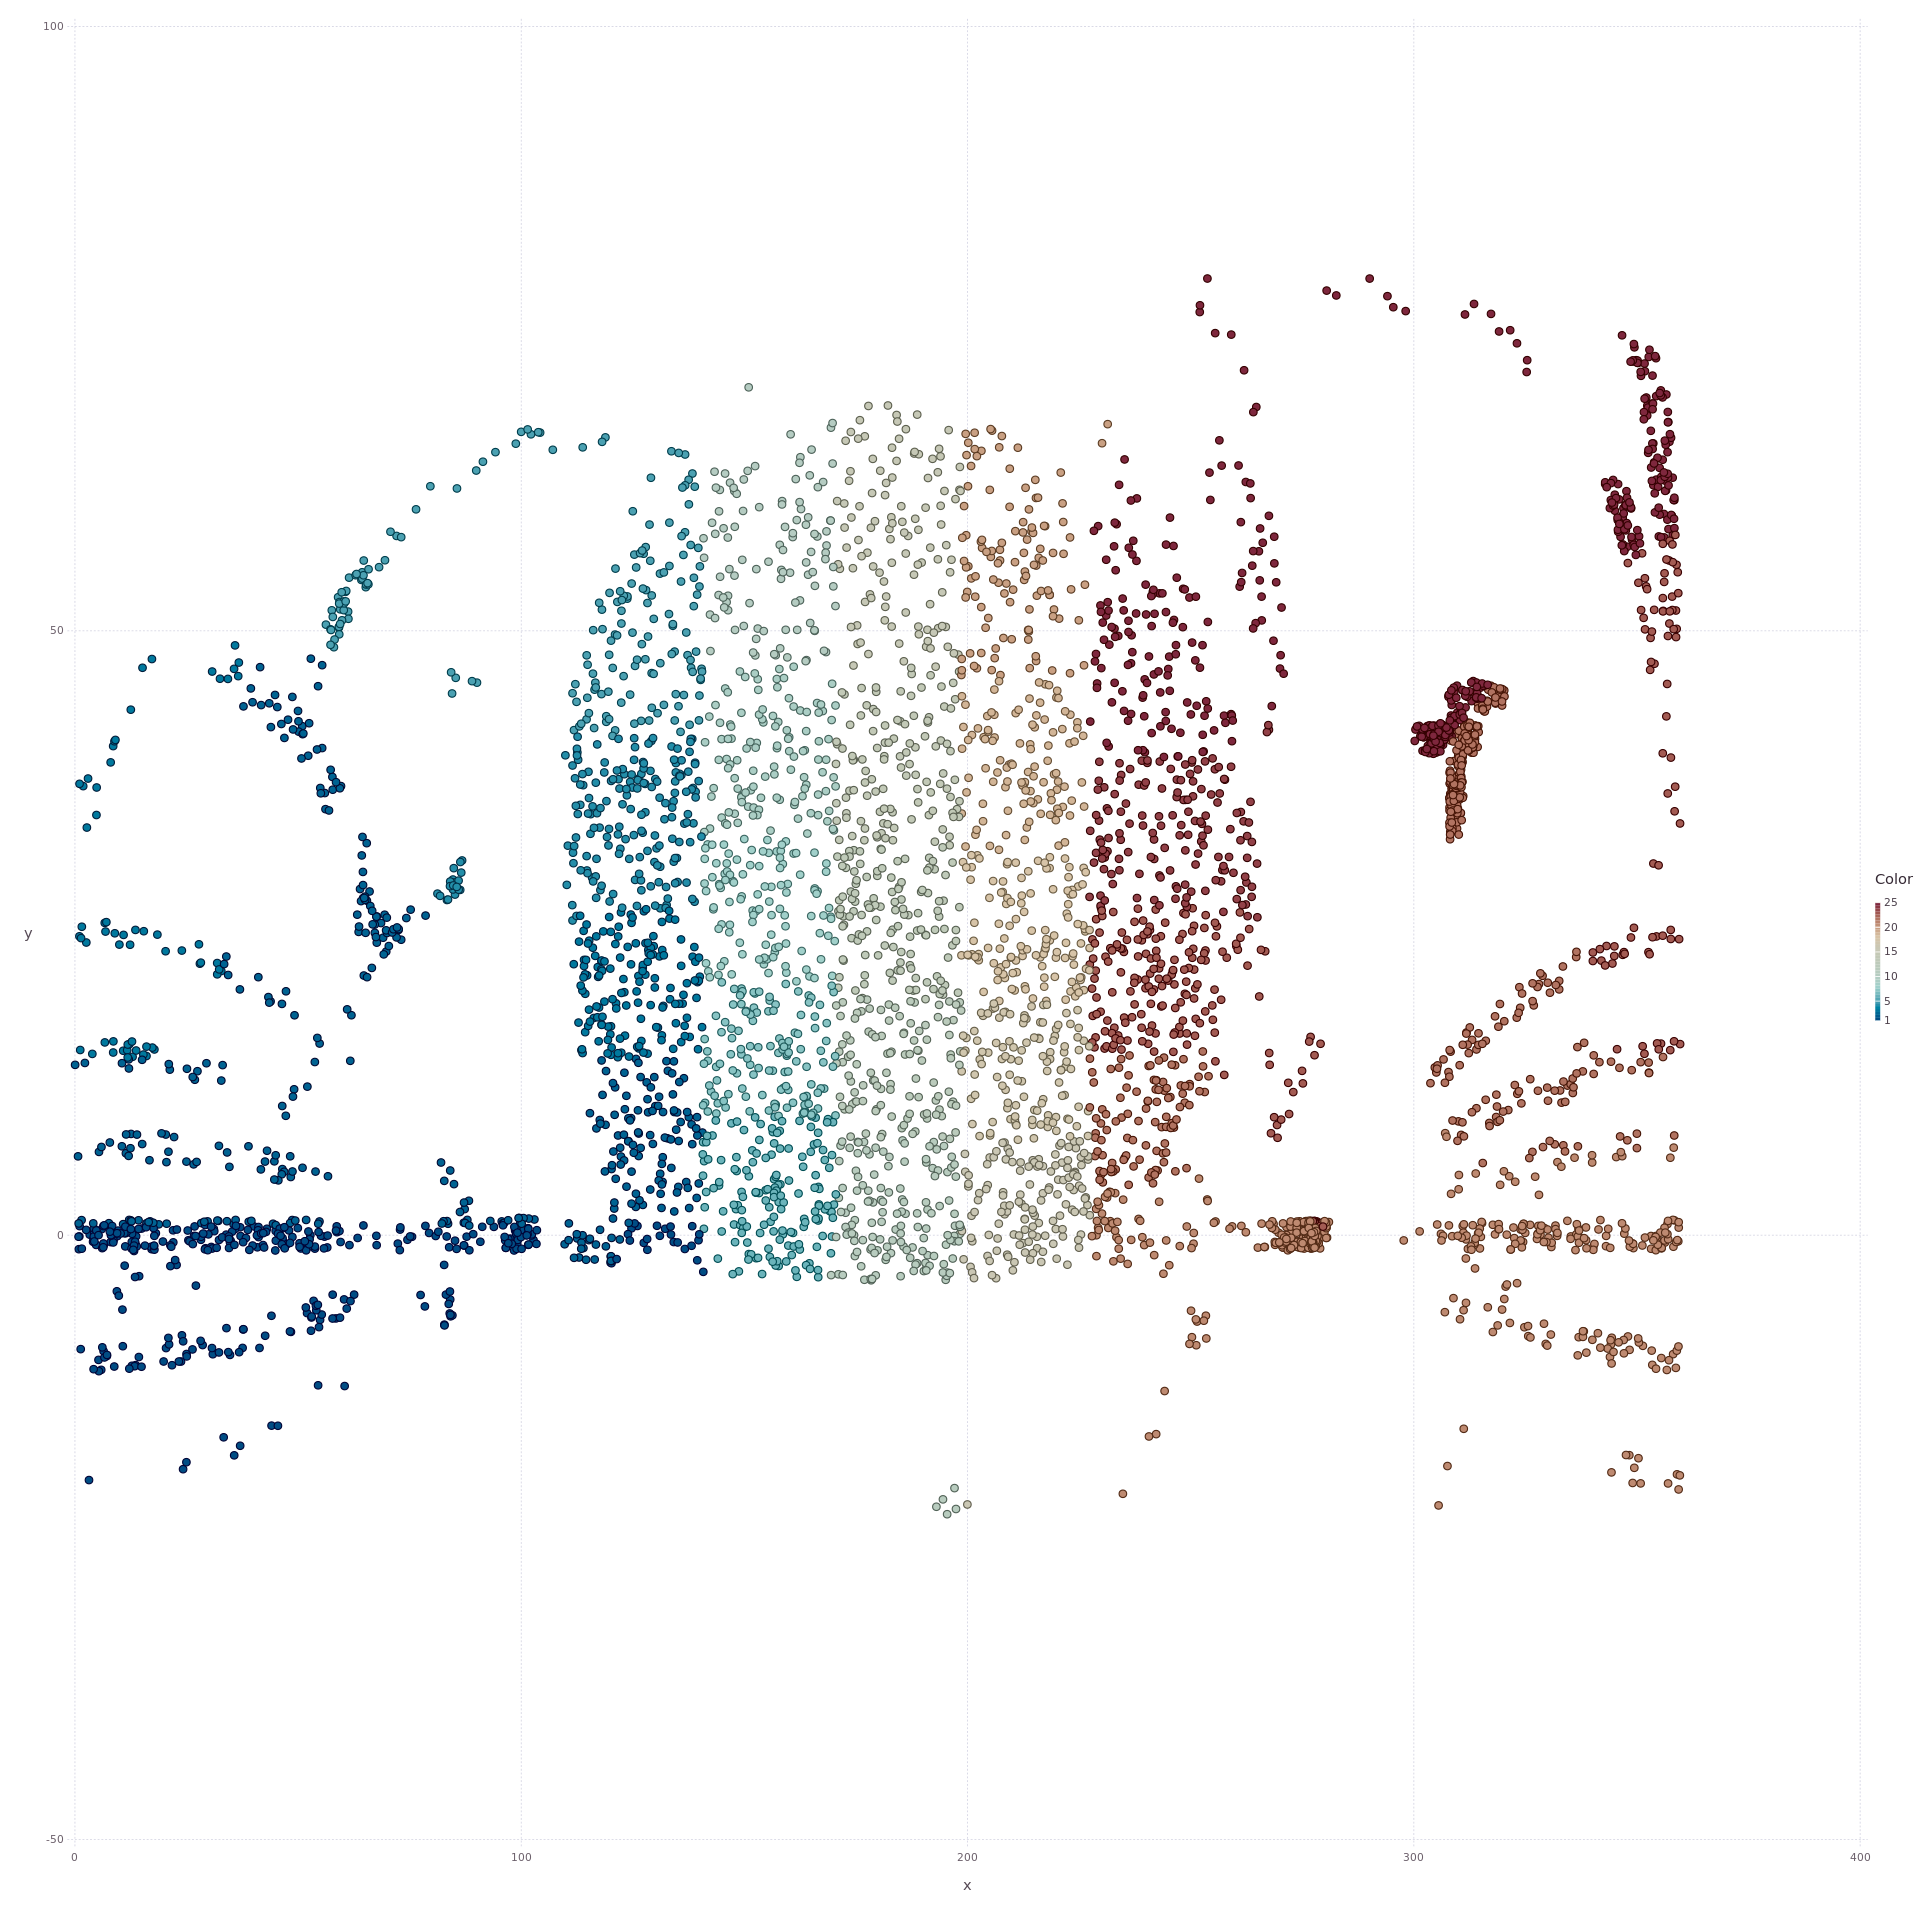

In [4]:
# now to show the results for a random subset of the data
randids = rand(1:length(ra), 5000)
fig = plot(x=ra[randids], y=dec[randids], color=subvols[randids],
           Geom.point, Theme(point_size=1.0mm))
draw(PNG("subvols.png", 20inch, 20inch), fig)
display("image/png", read("subvols.png"))

### Jackknife errors

Since this limited dataset just has the coordinates of the galaxies, we can compute a spatial quantity for each galaxy with which to perform a jackknife. I'll calculate the angular correlation function of the galaxies and estimate the errors using the jackknife function.

In [5]:
# first limit to data points more or less within the NGC to get something quicker to compute
mask = findall((105 .< ra .< 275) .& (dec .> -5))
ra = ra[mask]
dec = dec[mask]
dat = hcat(ra, dec)

# and same for randoms
randmask = findall((105 .< rands[:, 1] .< 275) .& (rands[:, 2] .> -5))
rands = rands[randmask, :]

# use a subsample of the data and randoms, to save on computation time/memory
ndat = 4000
nrands = 5 * ndat
dat = dat[rand(1:end, ndat), :]
rands = rands[rand(1:end, nrands), :]

# recompute the subvolumes for the subsamples, both data and randoms
subvols = get_subvols(dat, rands, 5, Distances.Haversine(1.0))
randsubvols = get_subvols(rands, rands, 5, Distances.Haversine(1.0))

20000-element Array{Int64,1}:
  2
 11
 18
  9
  4
 17
 12
 20
 15
 24
  1
 10
 15
  ⋮
 13
 18
 18
 11
 20
 25
 19
 25
 10
 13
 21
  2

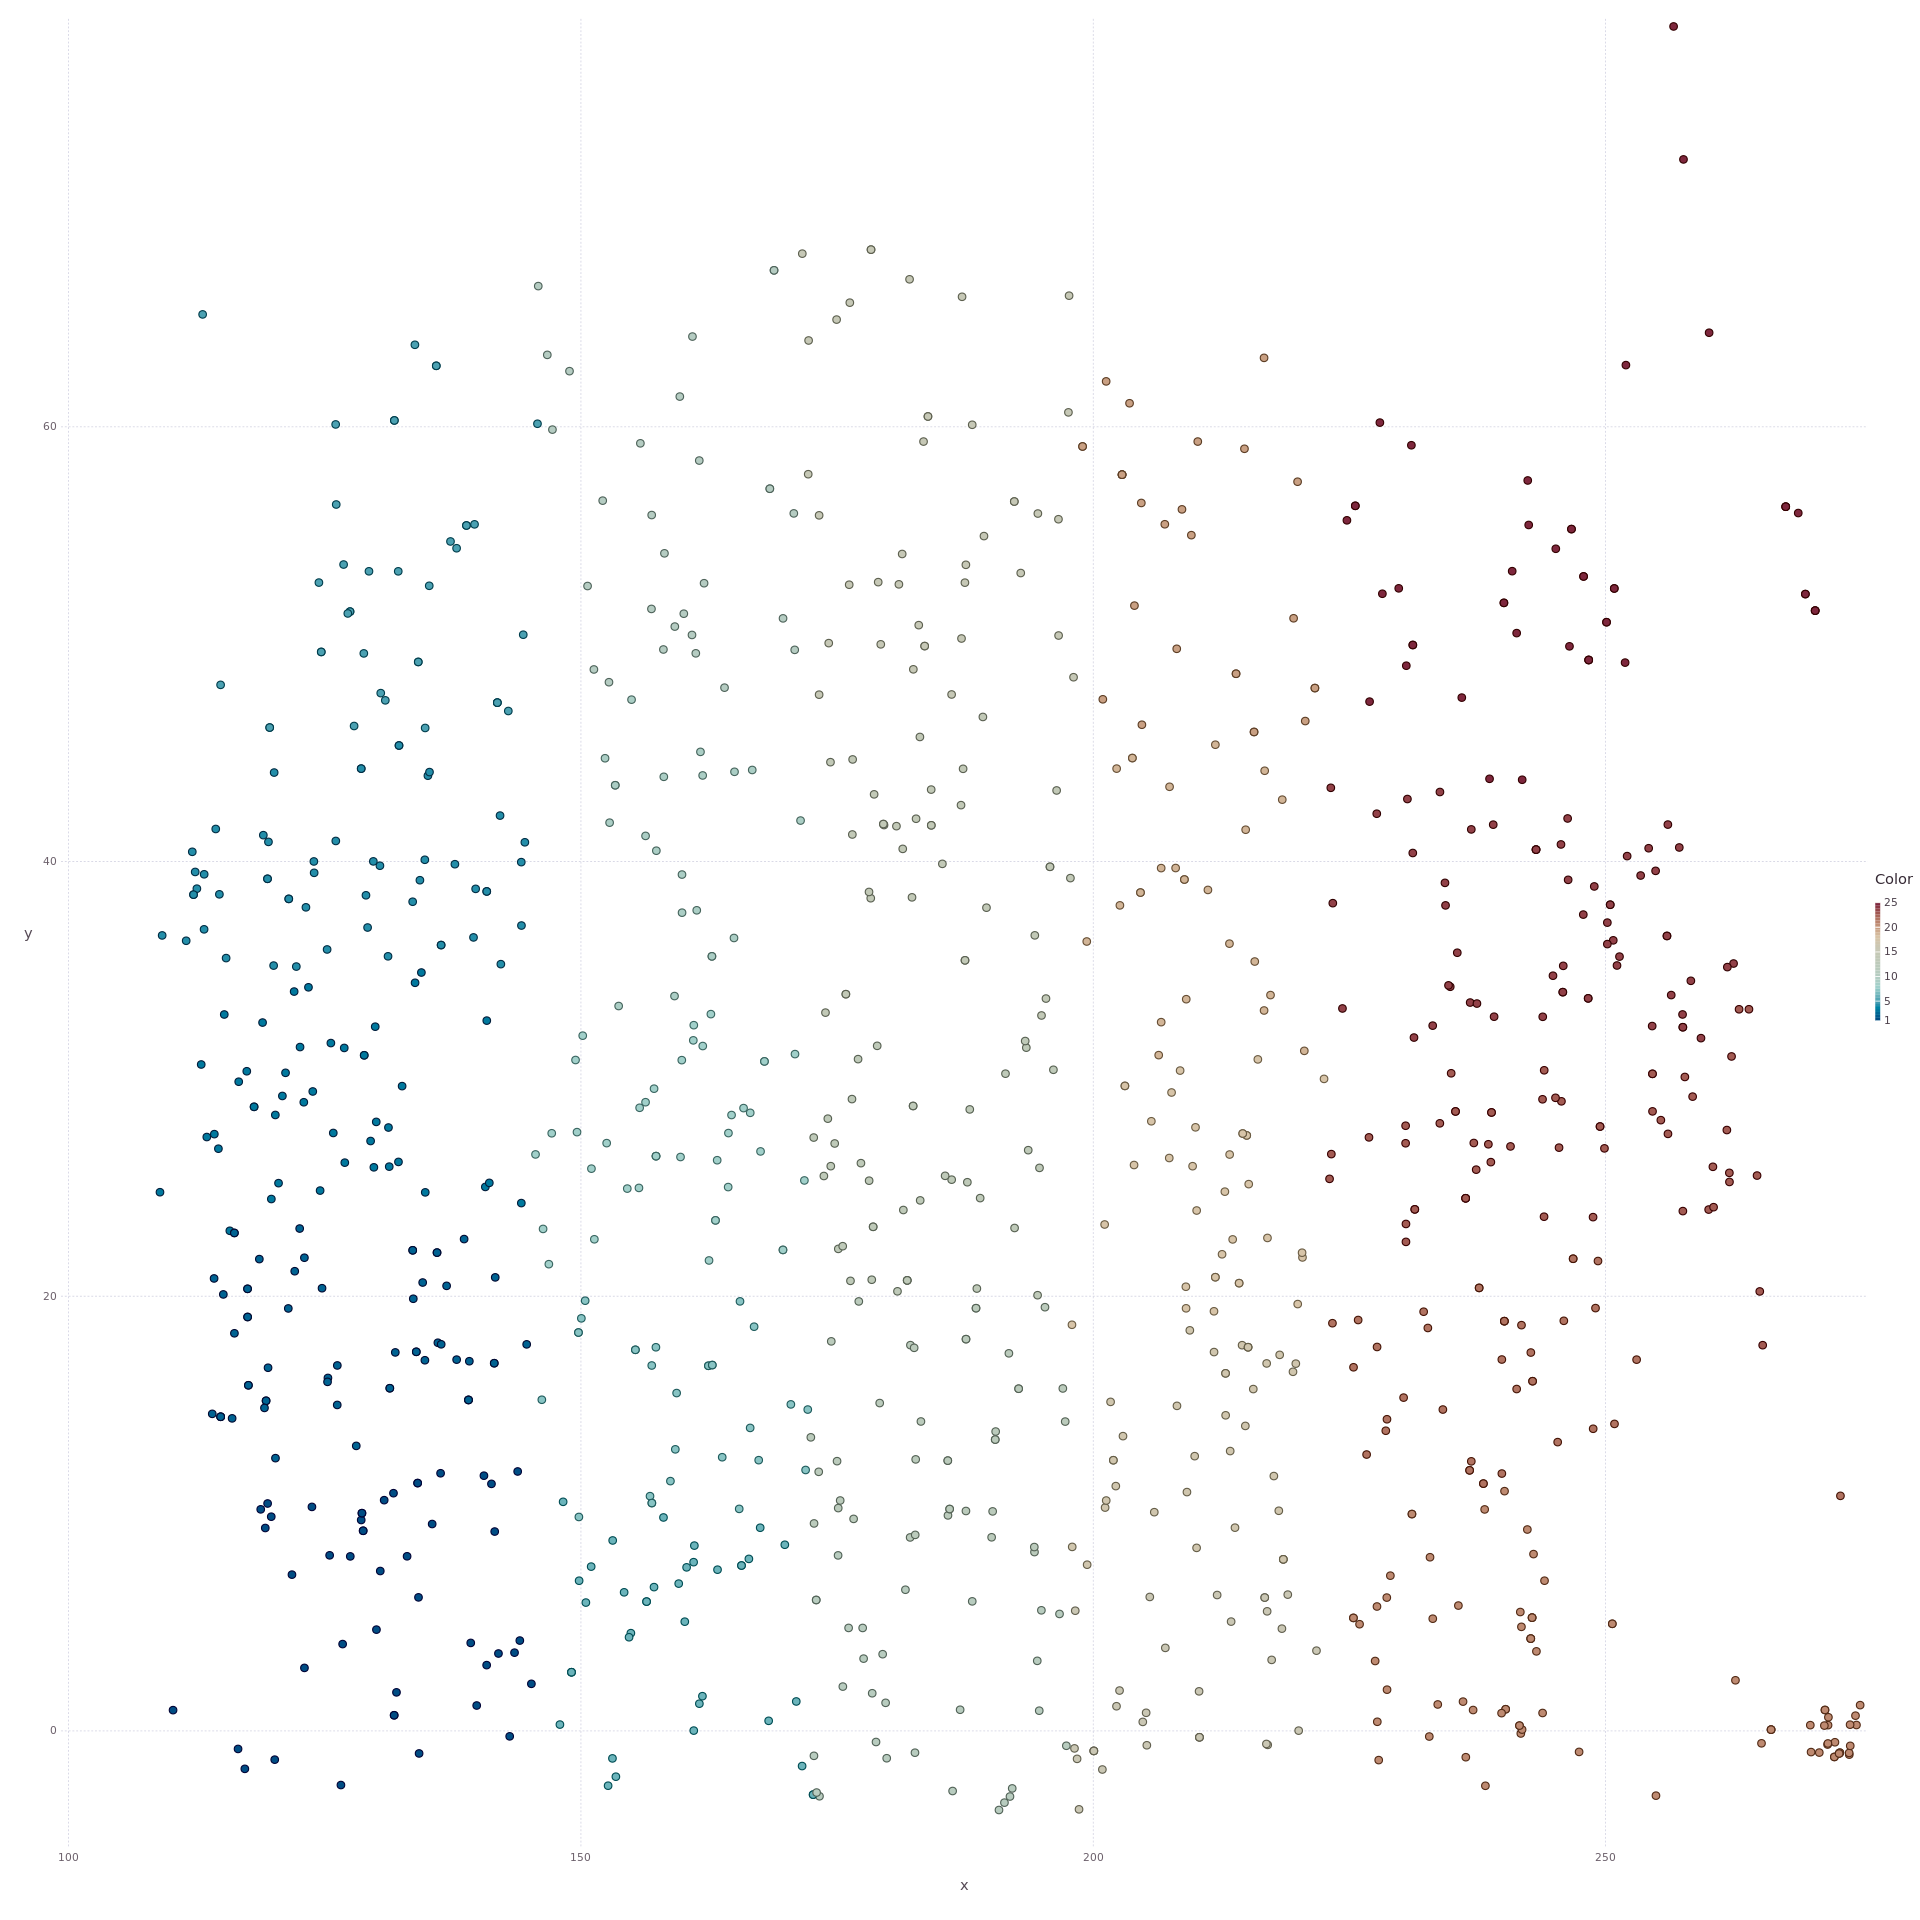

In [6]:
# now just to show the results of the new geometry for a small subset of the data
randids = rand(1:size(dat)[1], 1000)
fig = plot(x=dat[randids, 1], y=dat[randids, 2], color=subvols[randids],
           Geom.point, Theme(point_size=1.0mm),
           Coord.Cartesian(xmin=100, ymin=-5))
draw(PNG("subvols2.png", 20inch, 20inch), fig)
display("image/png", read("subvols2.png"))

In [7]:
# here is a function to pass to the jackknife method for finding angular correlation
function get_angcorr(dat::Array{Float64, 2},
                     rands::Array{Float64, 2},
                     randsubvols::Array{Int, 1},
                     ang_maxs::Array{Float64, 1},
                     subvol::Int)
    
    nbins = length(ang_maxs)
    
    # pick out only the randoms needed
    rands = rands[findall(randsubvols .!= subvol), :]
    
    # first construct a tree of randoms and get the random pairs
    tree = BallTree(collect(rands'), Distances.Haversine(1.0))
    
    randpairs = zeros(nbins)
    for i in 1:nbins
        pairinds = inrange(tree, collect(rands'), ang_maxs[i])
        randpairs[i] = sum([length(a) for a in pairinds])
    end
    
    # and the data-random pairs
    dr_pairs = zeros(nbins)
    for i in 1:nbins
        pairinds = inrange(tree, collect(dat'), ang_maxs[i])
        dr_pairs[i] = sum([length(a) for a in pairinds])
    end
    
    # now construct a data tree and get data pairs
    tree = BallTree(collect(dat'), Distances.Haversine(1.0))
    
    datpairs = zeros(nbins)
    for i in 1:nbins
        pairinds = inrange(tree, collect(dat'), ang_maxs[i])
        datpairs[i] = sum([length(a) for a in pairinds])
    end   
    
    # and compute correlation function estimator
    wtheta = @. (datpairs - (2 * dr_pairs) + randpairs) / randpairs
    
    wtheta
end

get_angcorr (generic function with 1 method)

now to run the correlation function jackknife

In [ ]:
# define edges of angular distance bins
ang_edges = 10 .^ range(-2, stop=1, length=16)
ang_maxs = ang_edges[2:end]

# and go
wmeans, wcovar = jackknife(get_angcorr, dat, subvols,
                           (rands, randsubvols, ang_maxs),
                           pass_vol = true)

In [ ]:
spy(wcovar)

In [ ]:
plot(x = 0.5 .* (ang_edges[1:(end - 1)] .+ ang_edges[2:end]),
     y = wmeans,
     ymin = wmeans .- diag(wcovar),
     ymax = wmeans .+ diag(wcovar),
     Geom.point, Geom.errorbar,
     Scale.x_log10, Scale.y_log10)

In [6]:
6

6